<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#Model-the-Data-with-DD-SIMCA" data-toc-modified-id="Model-the-Data-with-DD-SIMCA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model the Data with DD-SIMCA</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Create-a-Classifier" data-toc-modified-id="Create-a-Classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create a Classifier</a></span></li><li><span><a href="#Optimizing-the-Classifier" data-toc-modified-id="Optimizing-the-Classifier-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimizing the Classifier</a></span></li></ul></div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/pychemauth.git --depth 1
    !cd pychemauth; pip3 install .; cd ..

import pychemauth

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

Overview
-------------
This is a simple example of using DD-SIMCA to do some analysis.

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.33.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-48-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

matplotlib: 3.5.1
watermark : 2.3.1
sklearn   : 1.0.2
imblearn  : 0.7.0
pandas    : 1.3.5
numpy     : 1.21.5
pychemauth: 0.0.0a0



# Load the Data

In [4]:
# Let's load some data from the tests/ for this example
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/pychemauth/main/tests/data/simca_train.csv'
else:
    loc = '../tests/data/simca_train.csv'
df = pd.read_csv(loc)

In [5]:
# You can see that samples are rows, columns are different features
df.head()

,Group,Class,Name,3999,3991,3983,3975,3967,3959,3951,...,527,519,511,503,495,487,479,471,463,455
0,1,Pure,F 16 08 001 D,-0.968873,-0.969487,-0.970409,-0.969794,-0.970101,-0.971944,-0.970409,...,2.629155,2.652808,2.665095,2.684140,2.700114,2.693664,2.721617,2.728067,2.718238,2.668986
1,1,Pure,F 16 08 002 D,-0.965464,-0.964848,-0.965464,-0.966697,-0.966389,-0.968238,-0.968546,...,2.669310,2.672083,2.703205,2.711524,2.749117,2.733402,2.765756,2.758977,2.775000,2.714092
2,1,Pure,F 16 08 003 D,-0.968031,-0.969617,-0.968665,-0.970568,-0.970568,-0.970568,-0.971203,...,2.538191,2.525503,2.544218,2.570861,2.570544,2.567690,2.566421,2.566739,2.547390,2.592536
3,1,Pure,F 16 08 005 D,-0.957622,-0.957622,-0.958654,-0.958654,-0.960374,-0.959686,-0.957622,...,2.626278,2.622494,2.646919,2.666528,2.685448,2.685792,2.708497,2.693705,2.689920,2.707809
4,1,Pure,F 16 08 006 D,-0.960211,-0.961166,-0.961166,-0.961803,-0.961803,-0.962758,-0.963713,...,2.698431,2.711802,2.710846,2.746185,2.777385,2.767516,2.800307,2.807311,2.764331,2.773564


In [6]:
raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Class'].values, dtype=str) # Take the class as the target

# Model the Data with DD-SIMCA

In [7]:
from pychemauth.classifier.simca import DDSIMCA_Model

## Training

In [8]:
# Here the data is spectra so we will not scale the X data
dds = DDSIMCA_Model(n_components=7, alpha=0.05, gamma=0.01, scale_x=False)

In [9]:
_ = dds.fit(raw_x, raw_y)

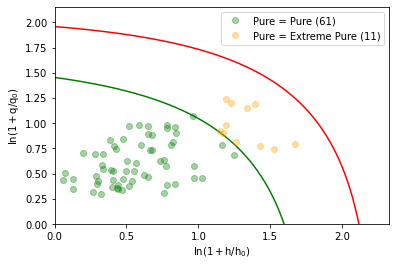

In [10]:
_ = dds.visualize(raw_x, raw_y)

In [11]:
# We can see what samples are classified as 'Pure' using the predict() function.
pure_sample_mask = dds.predict(raw_x)
len(pure_sample_mask)

72

In [12]:
# We could extract that data as follows:
pure = raw_x[pure_sample_mask]

In [13]:
# Extremes and Outliers can be found using the check_outliers() function.
extremes_mask, outliers_mask = dds.check_outliers(raw_x)

In [14]:
# We could extract that data as follows:
extremes = raw_x[extremes_mask]
outliers = raw_x[outliers_mask]

In [15]:
# Number of outliers, for example?
np.sum(outliers_mask)

0

In [16]:
# Number of extremes, for example?
np.sum(extremes_mask)

11

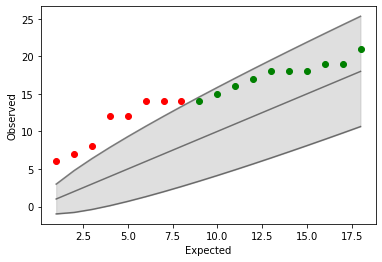

In [17]:
_ = dds.extremes_plot(raw_x, upper_frac=0.25)

## Testing

First, let's test on other pure samples that weren't in the training set.

In [18]:
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/pychemauth/main/tests/data/simca_test.csv'
else:
    loc = '../tests/data/simca_test.csv'
df = pd.read_csv(loc)

raw_x_t = np.array(df.values[:,3:], dtype=float)
raw_y_t = np.array(df.values[:,1], dtype=str)

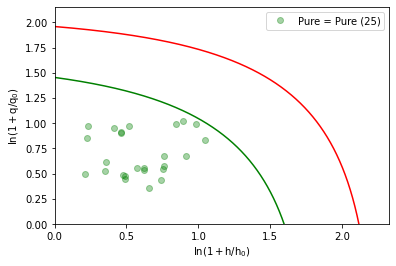

In [19]:
# Here, we would like to see all the points fall INSIDE the green acceptance region since we know they
# all belong to the 'Pure' class.
_ = dds.visualize(raw_x_t, raw_y_t)

We could also check against known alternates.

In [20]:
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/pychemauth/main/tests/data/simca_test_alt.csv'
else:
    loc = '../tests/data/simca_test_alt.csv'
df = pd.read_csv(loc, header=None)

raw_x_a = np.array(df.values[:,3:], dtype=float)
raw_y_a = np.array(df.values[:,1], dtype=str)

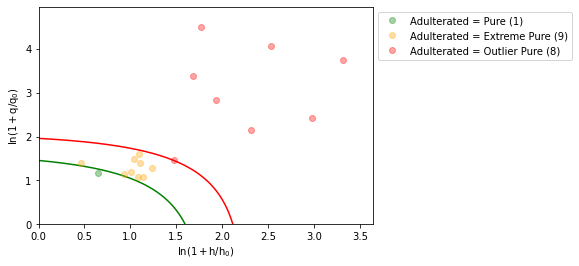

In [21]:
# Here, we would like to see all the points fall OUTSIDE the green acceptance region since we know they
# are not the 'Pure' class.
_ = dds.visualize(raw_x_a, raw_y_a)

# Create a Classifier

In the last section, we just created a DD-SIMCA Model. In practice, we would like to turn that into a classifier.  

In [22]:
from pychemauth.classifier.simca import SIMCA_Classifier

In [23]:
sc = SIMCA_Classifier(n_components=7, 
                      alpha=0.05, 
                      scale_x=False, 
                      style='dd-simca', 
                      target_class='Pure', 
                      use='compliant')

In [24]:
# Combine the training (all Pure) and alternate data to create a new training set that has multiple (in this
# case 2) classes.  We specified the target_class='Pure' above, which tells the classifier that we are trying
# to model that class.  ONLY that data is used to fit the model; all other classes it is provided will be
# ignored.
x_train = np.vstack((raw_x, raw_x_a))
y_train = np.hstack((raw_y, raw_y_a))
_ = sc.fit(x_train, y_train)

In [25]:
# By default, TEFF is used to score the classifer, you can change this when then classifier is instantiated.
sc.score(x_train, y_train) # TEFF = sqrt(TSNS * TSPS)

0.894513454894701

In [26]:
sc.metrics(x_train, y_train)

{'teff': 0.894513454894701,
 'tsns': 0.8472222222222222,
 'tsps': 0.9444444444444444,
 'csps': {'Adulterated': 0.9444444444444444}}

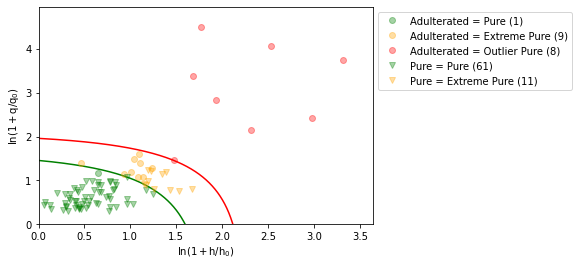

In [27]:
# Look at all the data.
_ = sc.model.visualize(x_train, y_train)

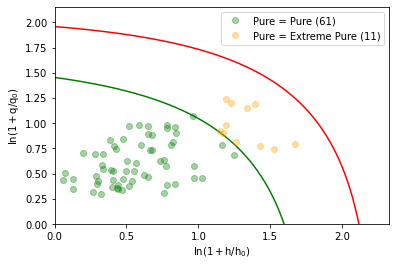

In [28]:
# Look at just the data used to train the underlying SIMCA_Model.
_ = sc.model.visualize(raw_x, raw_y)

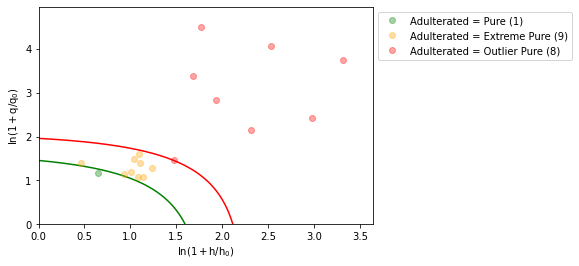

In [29]:
# Look at the data used to test how well the model performs by classifying alternative samples.
_ = sc.model.visualize(raw_x_a, raw_y_a)

# Optimizing the Classifier

Here we took alpha as a meaningful choice of type I error rate, but it could also be adjusted.  Moreover, we arbitrarily selected the number of PCs to use in the SIMCA model.  We can use scikit-learn's pipelines to automatically optimize hyperparameters like this.

In [30]:
# Here I've use an imblearn pipeline, but you can also use scikit-learn's pipeline if you don't want to 
# do any class balancing.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
    ("simca", SIMCA_Classifier(n_components=7, 
                               alpha=0.05, 
                               scale_x=False, 
                               style='dd-simca', 
                               target_class='Pure', 
                               use='compliant')
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    # 'smote__k_enn':[1, 2, 3],
    # 'smote__k_smote':[1, 3, 3],
    # 'smote__kind_sel_enn':['all', 'mode'],
    'simca__n_components':np.arange(1, 10),
    # 'simca__alpha':[0.07, 0.05, 0.03, 0.01],
    # 'simca__style':['dd-simca', 'simca'],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(x_train, y_train)

In [31]:
# The best parameters found can be accessed like this:
gs.best_params_

{'simca__n_components': 6}

In [32]:
gs.best_score_ # The best score it received was...

0.8327400767855689

In [33]:
# You can see detailed CV results here
gs.cv_results_

{'mean_fit_time': array([0.19092941, 0.17707046, 0.19842219, 0.21254778, 0.16568812,
        0.18275762, 0.17274102, 0.15079021, 0.13029504]),
 'std_fit_time': array([0.07346968, 0.02867959, 0.05117808, 0.05495326, 0.05752779,
        0.05104843, 0.04640707, 0.03353586, 0.01169117]),
 'mean_score_time': array([0.00179243, 0.00198849, 0.00164207, 0.00182907, 0.0016222 ,
        0.0017391 , 0.0019842 , 0.0016969 , 0.00169031]),
 'std_score_time': array([3.68567209e-04, 5.23932819e-04, 6.92044807e-05, 5.12373502e-04,
        1.73000021e-04, 1.87081610e-04, 2.53292958e-04, 4.11480829e-04,
        4.03156974e-05]),
 'param_simca__n_components': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'simca__n_components': 1},
  {'simca__n_components': 2},
  {'simca__n_components': 3},
  {'simca__n_components': 4},
  {'simca__n_compon

Text(0, 0.5, 'Mean Test Score (TEFF)')

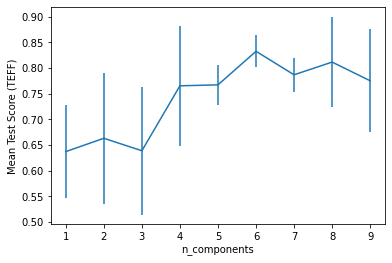

In [34]:
# For a 1D optimization you can easily visualize where the best value is
plt.errorbar(np.arange(1, 10), gs.cv_results_['mean_test_score'], yerr=gs.cv_results_['std_test_score'])
plt.xlabel('n_components')
plt.ylabel('Mean Test Score (TEFF)')

In [35]:
# The refit=True (default) refits the model on the data in the end so you can use it directly.
gs.best_estimator_.predict(raw_x) # raw_x was just Pure

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True])

In [36]:
gs.best_estimator_.predict(raw_x_a) # raw_x_a was just Alternates

array([ True, False, False,  True, False, False,  True, False, False,
        True, False, False, False, False, False,  True, False, False])

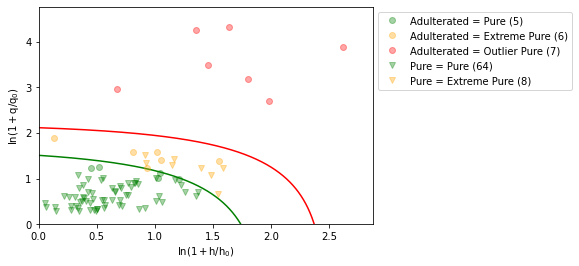

In [37]:
_ = gs.best_estimator_.named_steps['simca'].model.visualize(x_train, y_train)

In [38]:
gs.best_estimator_.named_steps['simca'].score(x_train, y_train) # The score being used here is TEFF

0.8012336167697753

In [39]:
gs.best_estimator_.named_steps['simca'].metrics(x_train, y_train)['tsns'] # 70 / (70+2)

0.8888888888888888

In [40]:
gs.best_estimator_.named_steps['simca'].metrics(x_train, y_train)['tsps'] # 1 - 4/(4+7+7)

0.7222222222222222

In [41]:
gs.best_estimator_.named_steps['simca'].metrics(x_train, y_train)['teff'] # sqrt(TSPS*TSNS)

0.8012336167697753